In [1]:
import inspect

import numpy as np
import pandas as pd
import scipy.optimize
import sympy

from main import gradient_descend, dichotomy_method, constant_rate, scipy_nelder_mead, golden_ratio_method
from utils import R2_derivatives, gen_func, plot_func, call_counter, plot_func_with_path_matplotlib, plot_2d_with_color, \
    plot_2d_and_3d_side_by_side

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from functools import wraps


def with_noise(func):
    @wraps(func)
    def new_func(x):
        return func(x) + np.random.normal(0, 0.001) 
    return new_func

In [4]:
func_coefs = [
    {'x^2': 0.1, 'y^2': 0.2},
    {'y^2': 1, 'x^2': 0.0031},
    {'x^2': 0.1, 'y^2': 0.1, 'xy': -0.3},
    # {'x^2': 0.0001, 'y^2': 0.0001},
]
funcs = [with_noise(gen_func(coefs)) for coefs in func_coefs]

In [5]:
# for func in funcs:
#     plot_func(func).show()

In [6]:
from typing import Optional
from dataclasses import dataclass


@dataclass
class OptimizationResult:
    minimum: np.ndarray
    iterations: int
    path: Optional[np.ndarray] = None
    simplexes: Optional[list[np.ndarray]] = None
    

In [7]:
def gradient_descend_constant_rate(start, dfs, f) -> OptimizationResult:
    res = gradient_descend(f, dfs, start, constant_rate(0.05), 1000, stop_point_delta=1e-6)
    return OptimizationResult(res.path[-1], res.iterations, res.path)

def gradient_descend_dichotomy(start, dfs, f) -> OptimizationResult:
    res = gradient_descend(f, dfs, start, dichotomy_method(0.05), 1000, stop_point_delta=1e-6)
    return OptimizationResult(res.path[-1], res.iterations, res.path)

def gradient_descend_golden_ratio(start, dfs, f) -> OptimizationResult:
    res = gradient_descend(f, dfs, start, golden_ratio_method(0.05), 1000, stop_point_delta=1e-6)
    return OptimizationResult(res.path[-1], res.iterations, res.path)

def scipy_nelder_mead_(start, dfs, f) -> OptimizationResult:
    path = []
    def callback(intermediate_result):
        path.append(intermediate_result['sim'])
    res = scipy_nelder_mead(f, start, callback=callback)
    return OptimizationResult(res.x, res.nit, simplexes=path)

methods = [
    gradient_descend_constant_rate,
    gradient_descend_dichotomy,
    gradient_descend_golden_ratio,
    scipy_nelder_mead_,
]

In [8]:
# inspect.getsource(scipy.optimize._optimize._minimize_neldermead)

In [9]:
# (scipy.optimize._optimize._minimize_neldermead).co

In [10]:
# def add_simplex_to_intermediate_result():
#     import scipy.optimize._optimize
#     code = inspect.getsource(scipy.optimize._optimize._minimize_neldermead)
#     marker = 'intermediate_result = OptimizeResult(x=sim[0], fun=fsim[0])'
#     need_to_add = "intermediate_result['sim'] = sim"
#     if need_to_add in code:
#         return
#     idx = code.index(marker)
#     code = code[:idx + len(marker)] + '; ' + need_to_add + code[idx + len(marker):]
#     exec(compile(code, '<object>', 'exec'))
#     scipy.optimize._optimize._minimize_neldermead = locals()['_minimize_neldermead']
#     minimize_code = inspect.getsource(scipy.optimize.minimize)    
#     exec(compile(minimize_code, '<object>', 'exec'))
#     scipy.optimize.minimize = locals()['minimize']

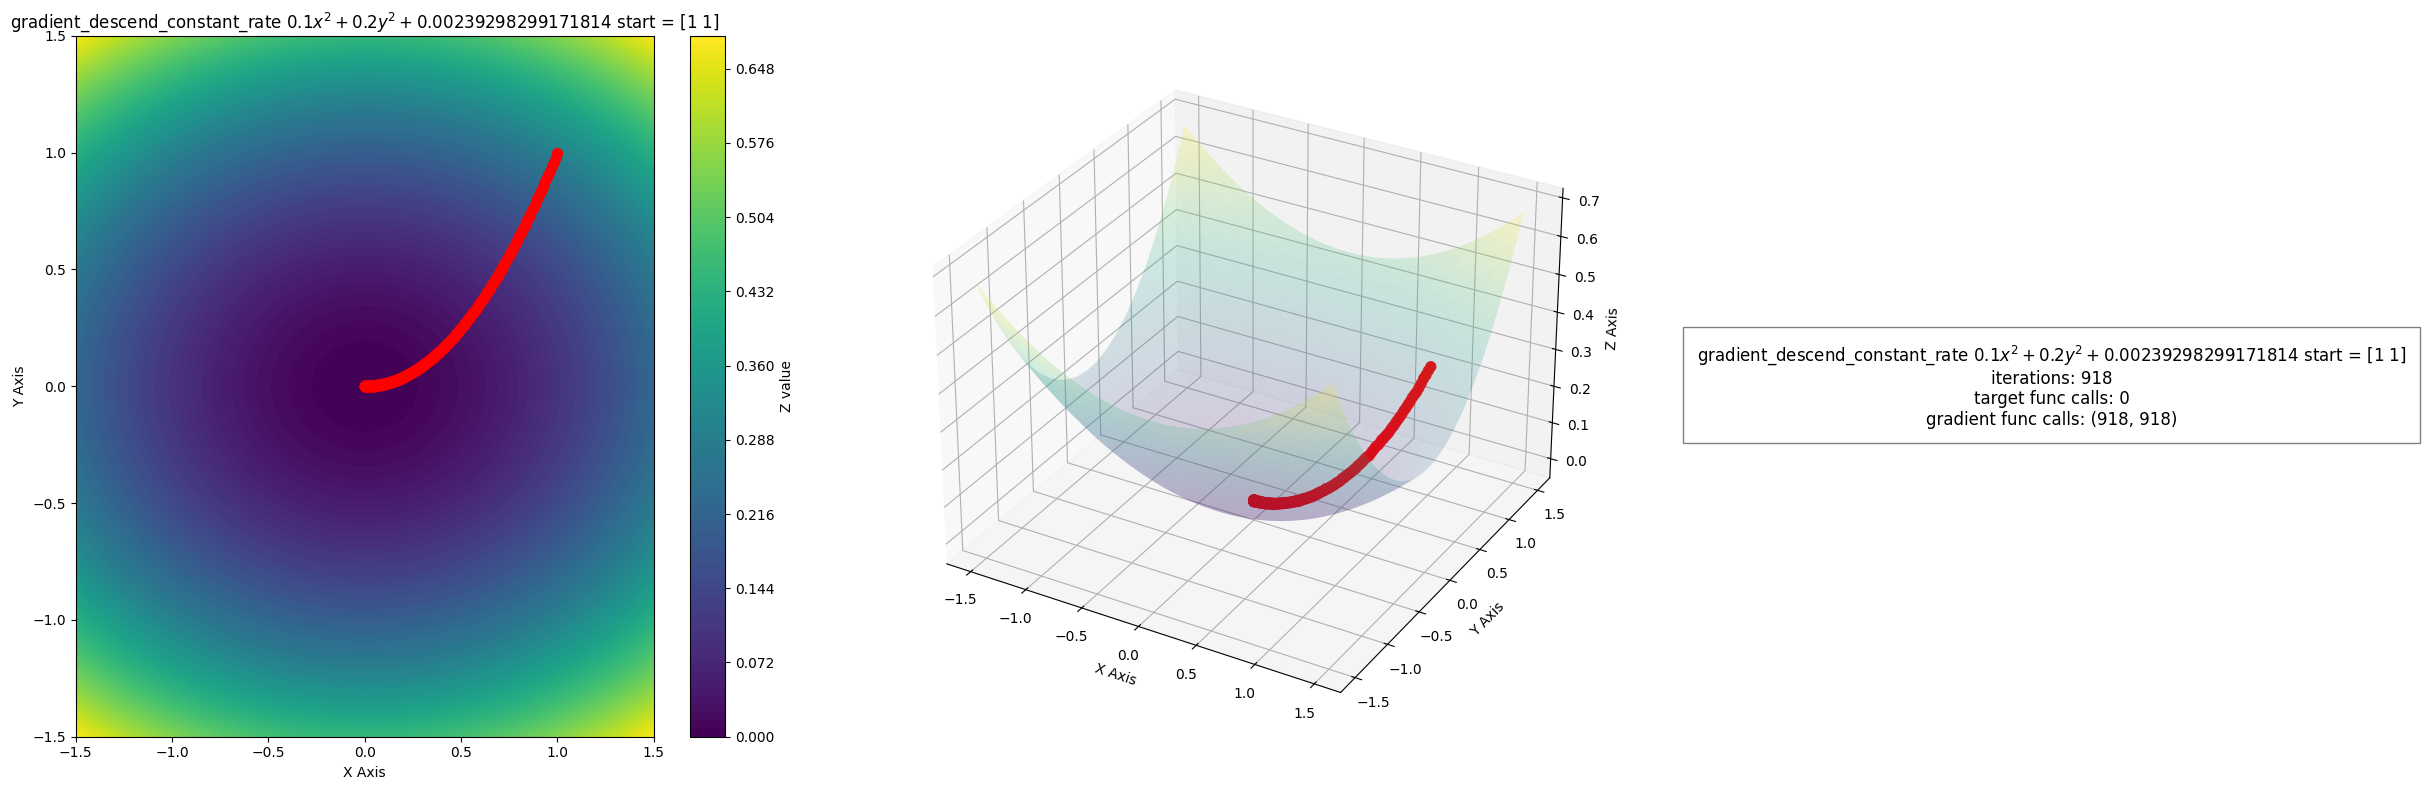

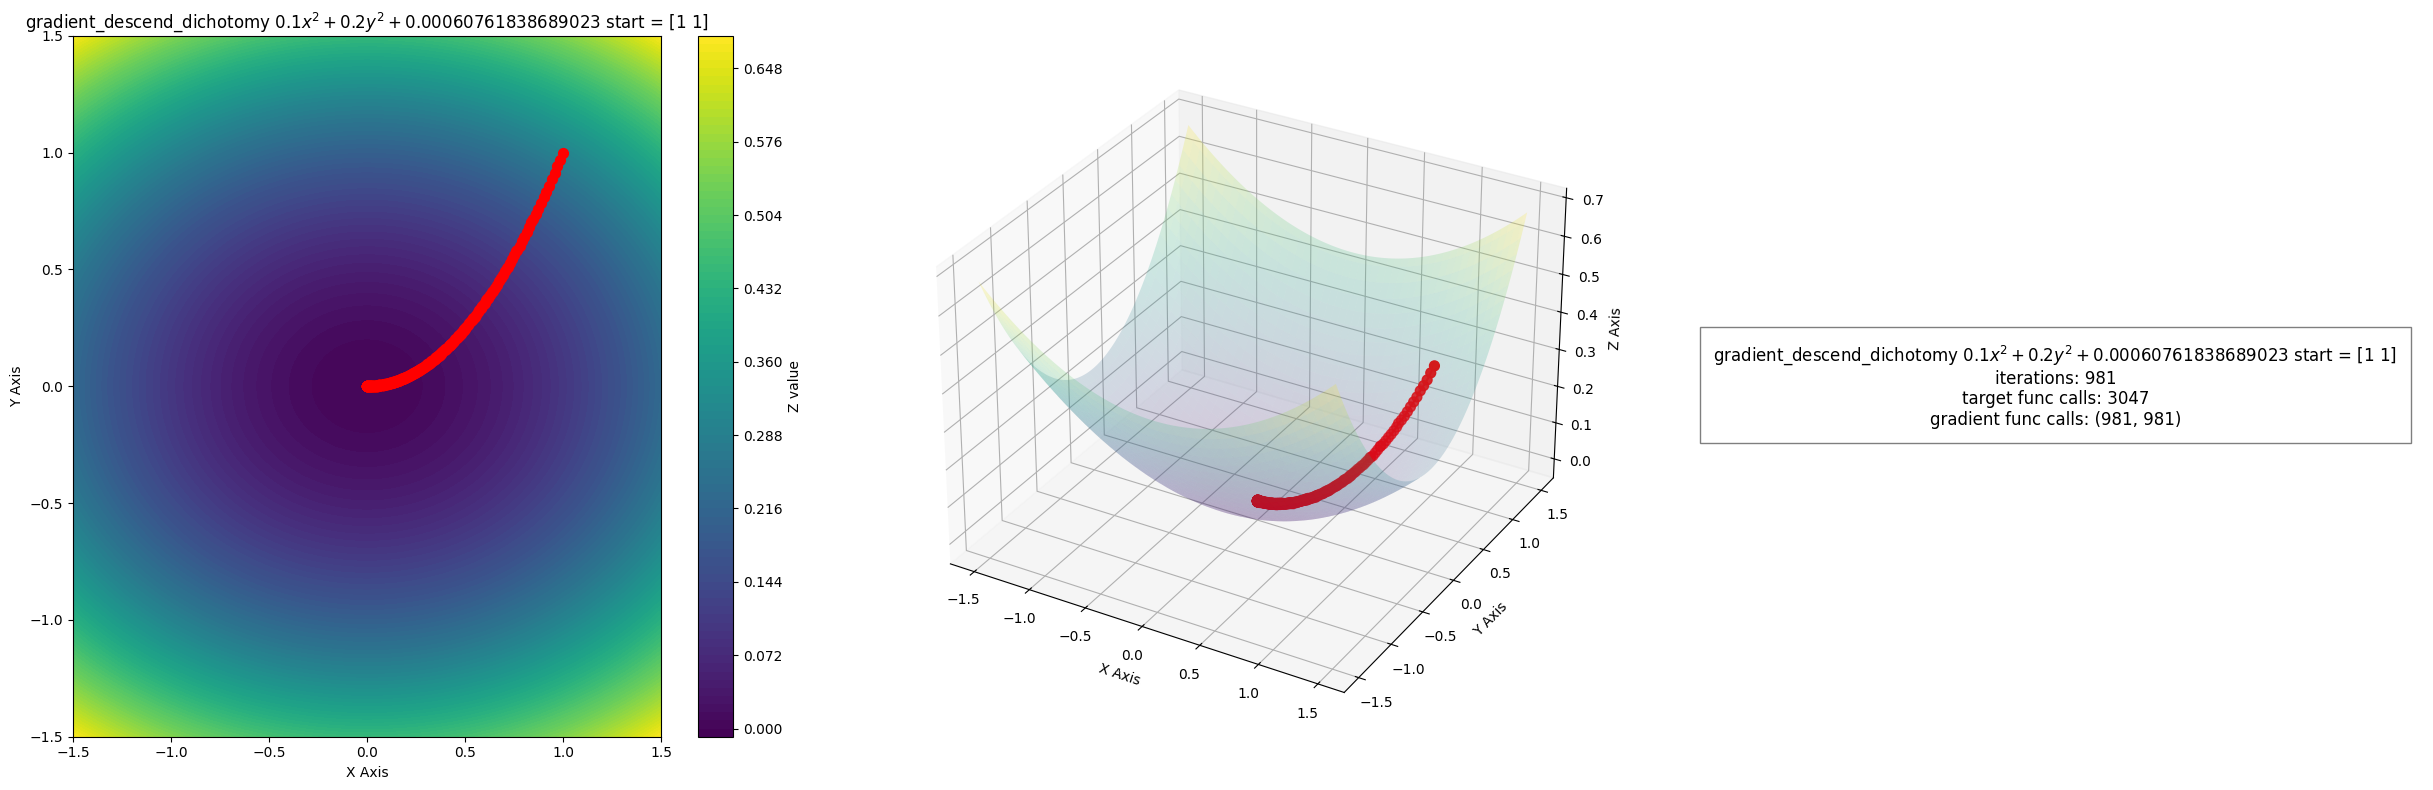

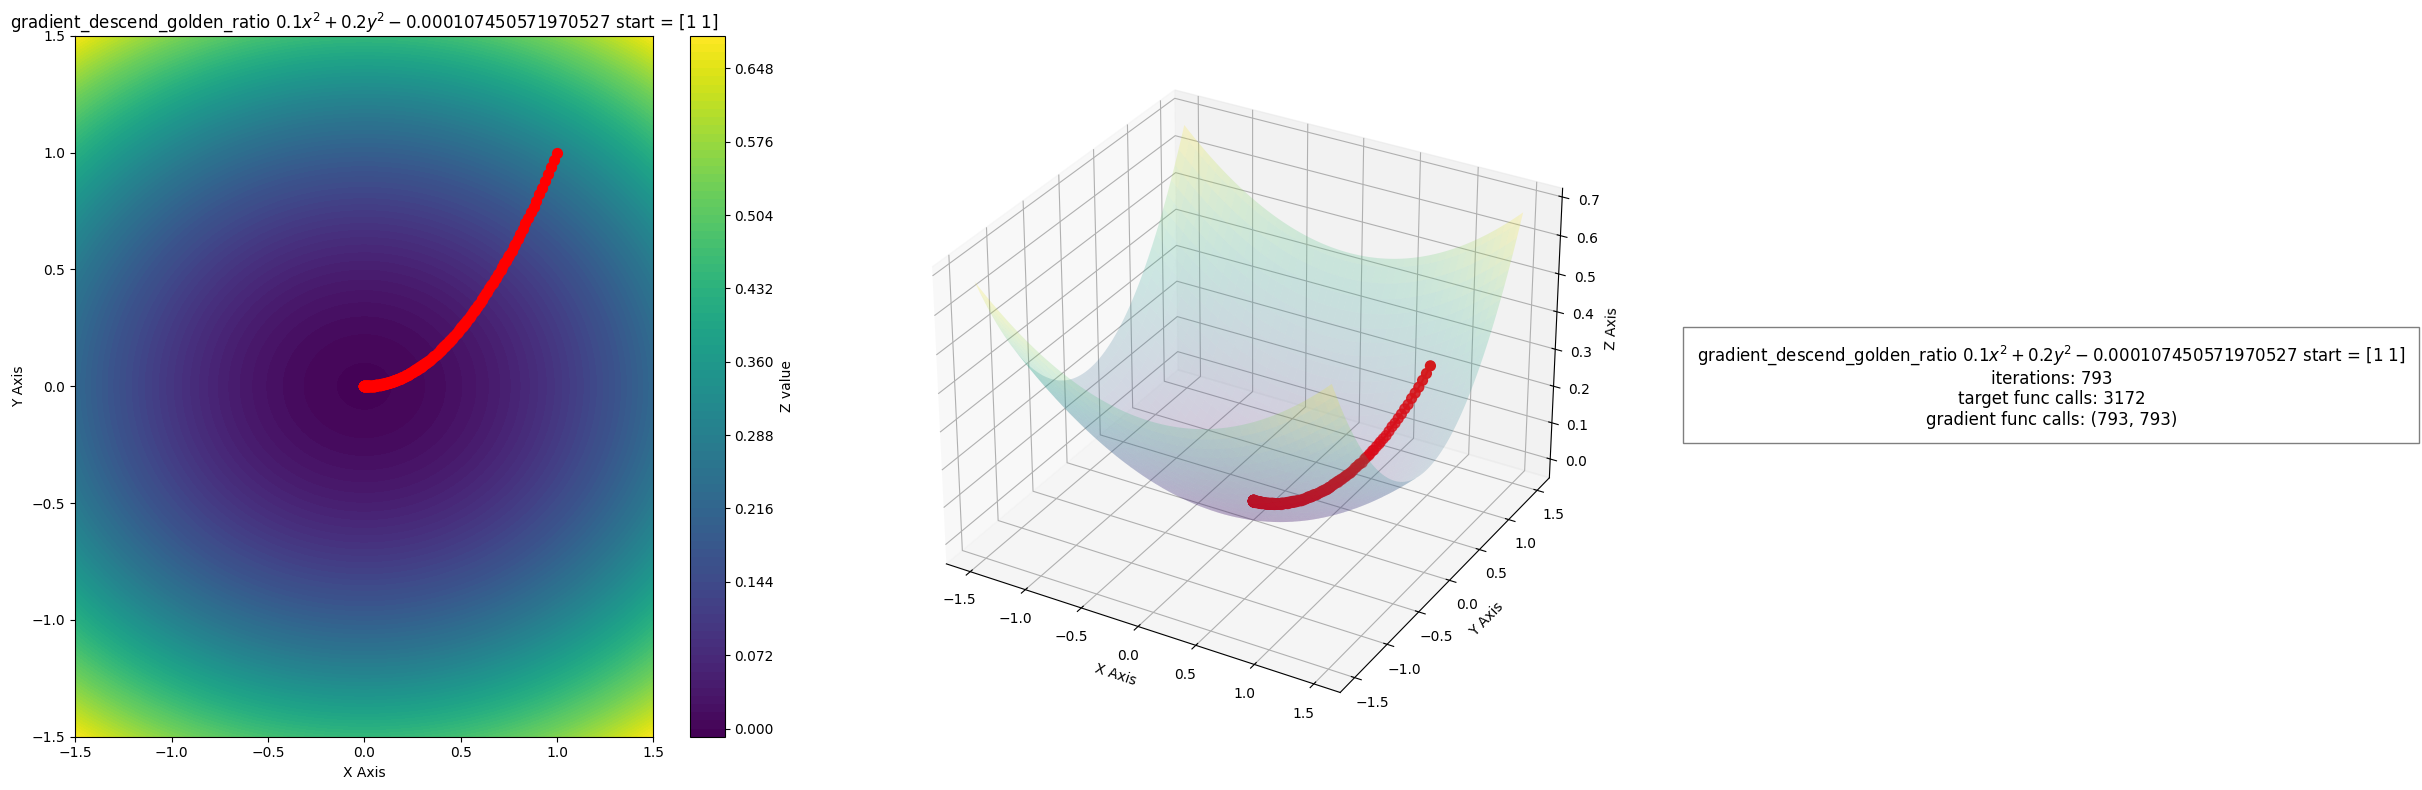

KeyError: 'sim'

In [11]:
records = []

# add_simplex_to_intermediate_result()

for coefs, func in zip(func_coefs, funcs):
    dfs = R2_derivatives(coefs)
    for start in map(np.array, [[1, 1], [10, 10], [200, 0]]):
        for method in methods:
            dfs_with_counter = [call_counter(d) for d in dfs]
            func_with_counter = call_counter(func)
            res = method(start, dfs_with_counter, func_with_counter)
            records.append({
                'coefs': coefs,
                'start': start,
                'method': method.__name__,
                'target func calls': func_with_counter.calls,
                'gradient func calls': tuple(d.calls for d in dfs_with_counter),
                'minimum': res.minimum,
                'path': res.path,
                'iterations': res.iterations,
            })
            title = fr'{method.__name__} ${sympy.latex(func(sympy.symbols("x y")))}$ start = {start}'
            text = title + f'\niterations: {res.iterations}\n'\
                   f'target func calls: {func_with_counter.calls}\n'\
                   f'gradient func calls: {tuple(d.calls for d in dfs_with_counter)}'
            plot_2d_and_3d_side_by_side(
                func, 
                res.path if res.path is not None else res.simplexes, 
                limit=max(start) * 1.5, issimplex=method == scipy_nelder_mead_,
                title=title, save=False, text=text
            )
            # plot_func(func, res.path).show()
        
        

In [ ]:
pd.DataFrame(records).to_csv('results1.csv')

In [ ]:
plot_func(funcs[0], records[0]['path']).write_image(f'images/{sympy.latex(funcs[0](sympy.symbols("x y")))}.png')

In [ ]:
plot_func_with_path_matplotlib(gen_func(records[10]['coefs']), records[10]['path'], limit=records[10]['start'].max())

In [ ]:
plot_2d_with_color(funcs[0], records[0]['path'], limit=1.1)

In [ ]:
records[3]['path']